<a href="https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/Baseline_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=677dc18db46c6297c741c5f535b1fa836d0650e8f8a7055462188d44569d9242
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [8]:
!pip install transformers

     |████████████████████████████████| 665kB 6.2MB/s 
     |████████████████████████████████| 3.8MB 17.4MB/s 
     |████████████████████████████████| 1.1MB 45.3MB/s 
     |████████████████████████████████| 890kB 42.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e5f2304ce5f4c1a3154f4ff5fb86a2388760cecc10a074295135b804456a85cd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## CUDA





In [0]:
import tensorflow as tf

In [0]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


Instal apex if you want to do 16 bit training. You'll probably need to restart the notebook after installing apex

## Import 





In [6]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import classification_report


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Download data and classification

### Download COLA Data

In [0]:
label2hot = {
  0: [1,0],
  1: [0,1]
}

In [469]:
!pip install wget
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'


# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [0]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [472]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,label,label_notes,sentence
r-67,1,NaN,What exploded when?
ks08,1,NaN,John can be dancing.
c_13,1,NaN,The cats ate the spider.
cj99,1,NaN,His expectations are always lower than mine.
g_81,0,*,The man who Mary loves and Sally hates George ...
ks08,1,NaN,His second book came out earlier this year and...
r-67,0,*,How brave Mike is cowardly and Sam is!
b_73,0,*,The table is longer than the door's wide.
r-67,1,NaN,I brought John a razor to shave himself with.
ks08,1,NaN,Kim regrets not having seen the movie.


In [447]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
bc01,"I did not, as Bill had thought, go to the store.",0
ad03,Which the poem did Homer recite?,0
bc01,"David is a great artist, and when he does, his...",0
r-67,Maxwell isn't half the doctor that I know an A...,0
rhl07,I lent the book halfway to Tony.,0


In [0]:
# Get the lists of sentences and their labels.
X_train = df.sentence.values
y_train = df.label.values

y_train_hotvec = [label2hot[l] for l in df.label.values]
y_train_hotvec = np.array(y_train_hotvec)

In [474]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
X_test = df.sentence.values
y_test = df.label.values

y_test_hotvec = [label2hot[l] for l in df.label.values]
y_test_hotvec = np.array(y_test_hotvec)

Number of test sentences: 516



Sanity check

In [0]:
import pickle

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

logits_train = load_from_pickle("/gdrive/My Drive/DataSet/BERT Models/BERTlogit_COLA_100p_Acc83_Mc50.pkl")

In [451]:
flat_predictions = np.argmax(logits_train, axis=1).flatten()
from sklearn.metrics import classification_report
print(classification_report(y_train, flat_predictions))
print(matthews_corrcoef(y_train, flat_predictions))

              precision    recall  f1-score   support

           0       0.86      0.52      0.65      2528
           1       0.83      0.96      0.89      6023

    accuracy                           0.83      8551
   macro avg       0.84      0.74      0.77      8551
weighted avg       0.84      0.83      0.82      8551

0.5778340438547784


In [0]:
y_train_psedu = np.array([label2hot[l] for l in flat_predictions])

### Download SST2 Data

In [0]:
label2hot = {
  0: [1,0],
  1: [0,1]
}

In [8]:
import pandas as pd

# Load the dataset into a pandas dataframe.

df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 6,920



,0,1
2529,psychologically revealing,1
1276,"passionate , irrational , long suffering but c...",1
1166,do n't let the subtitles fool you the movie on...,0
949,but it 's hardly a necessary enterprise,0
1730,definitely worth 95 minutes of your time,1
6151,very predictable but still entertaining,1
2227,there 's real visual charge to the filmmaking ...,1
16,"if the tuxedo actually were a suit , it would ...",0
1870,in addition to hoffman 's powerful acting clin...,1
1760,what ` blade runner ' would 've looked like as...,0


In [0]:
text_col=df.columns.values[0] 
category_col=df.columns.values[1]

# Get the lists of sentences and their labels.
X_train = df[text_col]
y_train = df[category_col]

y_train_hotvec = [label2hot[l] for l in df[category_col].values]
y_train_hotvec = np.array(y_train_hotvec)

In [10]:
# Load the test dataset into a pandas dataframe.
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
X_test = df[text_col]
y_test = df[category_col]

y_test_hotvec = [label2hot[l] for l in df[category_col].values]
y_test_hotvec = np.array(y_test_hotvec)

Number of test sentences: 1,821



In [0]:
import pickle

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

logits_train = load_from_pickle("/gdrive/My Drive/DataSet/BERT Models/BERTlogit_STS2_100p_Acc91.pkl")

In [294]:
flat_predictions = np.argmax(logits_train, axis=1).flatten()
from sklearn.metrics import classification_report
print(classification_report(y_train, flat_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3310
           1       0.99      0.98      0.99      3610

    accuracy                           0.99      6920
   macro avg       0.99      0.99      0.99      6920
weighted avg       0.99      0.99      0.99      6920



In [0]:
y_train_psedu = np.array([label2hot[l] for l in flat_predictions])

### Download IMDB Data

In [0]:
# https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0
import pandas as pd
import re
from os import system, listdir
from os.path import isfile, join
from random import shuffle
import random

random.seed(42)

system('wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"')
system('tar -xzf "aclImdb_v1.tar.gz"')

def create_data_frame(folder: str) -> pd.DataFrame:
    '''
    folder - the root folder of train or test dataset
    Returns: a DataFrame with the combined data from the input folder
    '''
    pos_folder = f'{folder}/pos' # positive reviews
    neg_folder = f'{folder}/neg' # negative reviews
    
    def get_files(fld: str) -> list:
        '''
        fld - positive or negative reviews folder
        Returns: a list with all files in input folder
        '''
        return [join(fld, f) for f in listdir(fld) if isfile(join(fld, f))]
    
    def append_files_data(data_list: list, files: list, label: int) -> None:
        '''
        Appends to 'data_list' tuples of form (file content, label)
        for each file in 'files' input list
        '''
        for file_path in files:
            with open(file_path, 'r') as f:
                text = f.read()
                data_list.append((text, label))
    
    pos_files = get_files(pos_folder)
    neg_files = get_files(neg_folder)
    
    data_list = []
    append_files_data(data_list, pos_files, 1)
    append_files_data(data_list, neg_files, 0)
    shuffle(data_list)
    
    text, label = tuple(zip(*data_list))
    # replacing line breaks with spaces
    text = list(map(lambda txt: re.sub('(<br\s*/?>)+', ' ', txt), text))
    
    return pd.DataFrame({'text': text, 'label': label})

imdb_train = create_data_frame('aclImdb/train')
imdb_test = create_data_frame('aclImdb/test')

system("mkdir 'csv'")
imdb_train.to_csv('csv/imdb_train.csv', index=False)
imdb_test.to_csv('csv/imdb_test.csv', index=False)

In [85]:
import pandas as pd

# Load the dataset into a pandas dataframe.

#df = pd.read_csv('/gdrive/My Drive/DataSet/IMDB/imdb_train.csv')
df = pd.read_csv('csv/imdb_train.csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display first 10 rows from the data.
df.head()

Number of training sentences: 25,000



,text,label
0,This is the worst movie I have ever seen. I wa...,0
1,This movie was excellent. It details the strug...,1
2,Back in 74 Eric Monte made the classic T.V sho...,1
3,"Superficically, ""Brigadoon"" is a very promisin...",0
4,"""The Straight Story"" is a truly beautiful movi...",1


In [0]:
label2hot = {
  0: [1,0],
  1: [0,1]
}

In [0]:
X_train = df.text.values
y_train = df.label.values

y_train_hotvec = [label2hot[l] for l in df.label.values]
y_train_hotvec = np.array(y_train_hotvec)

In [88]:
# Load the test dataset into a pandas dataframe.

#df = pd.read_csv('/gdrive/My Drive/DataSet/IMDB/imdb_test.csv')
df = pd.read_csv('csv/imdb_test.csv')

df.head()

,text,label
0,I am writing this with 10 minutes left before ...,0
1,I saw this Film one midnight and I can say tha...,0
2,"I would say 'Bride of Chucky' is a ""return to ...",1
3,"***SPOILERS*** ***SPOILERS*** Well, seeing as ...",1
4,MR. BASEBALL is a film of paradoxes. Written a...,1


In [89]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
X_test = df.text.values
y_test = df.label.values

y_test_hotvec = [label2hot[l] for l in df.label.values]
y_test_hotvec = np.array(y_test_hotvec)

Number of test sentences: 25,000



In [0]:
import pickle

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

logits_train = load_from_pickle("/gdrive/My Drive/DataSet/BERT Models/BERTlogit_IMDB_100p_Acc89.pkl")

In [15]:
logits_train[0:10]

array([[ 4.319991 , -3.7680566],
       [-3.696197 ,  3.4553776],
       [-3.8063266,  3.413912 ],
       [ 3.0629084, -2.9434607],
       [-3.9281726,  3.6189125],
       [-2.8333375,  2.2253618],
       [ 3.9994729, -3.4339283],
       [-3.7564743,  3.4465153],
       [ 4.330141 , -3.8781044],
       [-3.659255 ,  3.5838134]], dtype=float32)

Sanity check (must be same as acc attribute)

In [363]:
flat_predictions = np.argmax(logits_train, axis=1).flatten()
from sklearn.metrics import classification_report
print(classification_report(y_train, flat_predictions))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     12500
           1       0.90      0.92      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



In [0]:
y_train_psedu = np.array([label2hot[l] for l in flat_predictions])

Load BERT Logits

### Download MRPC Data

In [0]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/utils/download_glue_data.py -qq
!python download_glue_data.py

	Completed!
	Completed!
Processing MRPC...
Local MRPC data not specified, downloading data from https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!


### Download ED6 Data

In [108]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2020-05-29 11:03:29--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2020-05-29 11:03:29--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc06bbdb174b4c9681af092325a9.dl.dropboxusercontent.com/cd/0/inline/A4o5vZ00j07tjvRvcR0E05IeYDYecm6EcsMhas1SO5yJ4pgGy3gwTWOwQ2GOYeHOuQ4AdyWoWKgb5zHjU9PHk2G5RV9rExDBtWOXIjZS0tgStOob8ZOi5FNEBjn-Fra-TQU/file# [following]
--2020-05-29 11:03:30--  https://uc06bbdb174b4c9681af092325a9.dl.dropboxusercontent.com/cd/0/inline/A4o5vZ00j07tjvRvcR0E05IeYDYecm6EcsMhas1SO5yJ4pgGy3gwTWOwQ2GOYeHOuQ4AdyWoWKgb5zHjU9PHk2G5RV9rExDBtWOXIjZS0tgStOob8ZOi5FNEBjn-Fr

In [109]:
!mkdir emotion_data
!mv *.txt emotion_data

mkdir: cannot create directory ‘emotion_data’: File exists


In [0]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

In [0]:
label2hot = {
  "sadness": [1,0,0,0,0,0],
  "joy": [0,1,0,0,0,0],
  "love": [0,0,1,0,0,0],
  "anger": [0,0,0,1,0,0],
  "fear": [0,0,0,0,1,0],
  "surprise": [0,0,0,0,0,1]
}

value2hot = {
  0: [1,0,0,0,0,0],
  1: [0,1,0,0,0,0],
  2: [0,0,1,0,0,0],
  3: [0,0,0,1,0,0],
  4: [0,0,0,0,1,0],
  5: [0,0,0,0,0,1]
}


In [0]:
label2int['surprise']

5

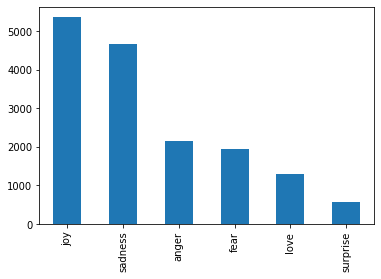

In [112]:
import pandas as pd
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
data.emotion.value_counts().plot.bar()

In [382]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data.
data.sample(10)

Number of training sentences: 16,000



,text,emotion
228,i can feel that she smiled i love you even mor...,joy
9928,im feeling pressured because it is crunch time...,fear
3672,ive been feeling really caring towards jt,love
997,i get home i laze around in my pajamas feeling...,anger
1936,i feel i would be ungrateful to god and unduti...,sadness
5670,i just feel so amazingly appreciative of my lj...,joy
8965,i go back to that day however and hear jesus w...,fear
3440,i was reluctant but hey i was feeling so lousy...,sadness
2339,i had thought but i feel scared and somewhat t...,fear
14431,i feel like there s a possibility that stateme...,joy


In [0]:
import numpy as np
X_train = data.text.values
labels = [label2int[l] for l in data.emotion]
y_train = np.array(labels)

In [0]:
from sklearn import preprocessing
# Binarization
### convert targets to one-hot encoding vectors
#emotions = list(set(data.emotion.unique()))
#num_emotions = len(emotions)
#mlb = preprocessing.MultiLabelBinarizer()

#train_labels =  [set(emos) & set(emotions) for emos in data[['emotion']].values]
#bin_emotions = mlb.fit_transform(train_labels)
#y_train_mlb = np.array(bin_emotions.tolist())

In [0]:
y_train_hotvec = [label2hot[l] for l in data.emotion.values]
y_train_hotvec = np.array(y_train_hotvec)

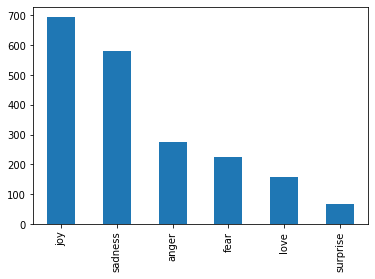

In [115]:
#Load test dataset
data = pd.read_csv(test_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
data.emotion.value_counts().plot.bar()

In [116]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(data.shape[0]))

# Create sentence and label lists
X_test = data.text.values
labels = [label2int[l] for l in data.emotion]
y_test = np.array(labels)

Number of test sentences: 2,000



In [0]:
from sklearn import preprocessing
# Binarization
### convert targets to one-hot encoding vectors
#emotions = list(set(data.emotion.unique()))
#num_emotions = len(emotions)
#mlb = preprocessing.MultiLabelBinarizer()

#test_labels =  [set(emos) & set(emotions) for emos in data[['emotion']].values]
#bin_emotions = mlb.fit_transform(test_labels)
#y_test_mlb = np.array(bin_emotions.tolist())

In [0]:
y_test_hotvec = [label2hot[l] for l in data.emotion.values]
y_test_hotvec = np.array(y_test_hotvec)

In [0]:
import pickle

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

logits_train = load_from_pickle("/gdrive/My Drive/DataSet/BERT Models/BERTlogit_ED6_100p_Acc93.pkl")

In [429]:
flat_predictions = np.argmax(logits_train, axis=1).flatten()
from sklearn.metrics import classification_report
print(classification_report(y_train, flat_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4666
           1       0.99      0.97      0.98      5362
           2       0.89      0.95      0.92      1304
           3       0.98      0.97      0.97      2159
           4       0.93      0.96      0.95      1937
           5       0.89      0.86      0.88       572

    accuracy                           0.97     16000
   macro avg       0.94      0.95      0.95     16000
weighted avg       0.97      0.97      0.97     16000



In [0]:
y_train_psedu = np.array([value2hot[l] for l in flat_predictions])

Data Augmentation

In [0]:
import pickle

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

logits_train = load_from_pickle("/gdrive/My Drive/DataSet/BERT Models/BERTlogit_ED6_Aug_Acc93.pkl")

In [0]:
data = pd.read_csv('/gdrive/My Drive/DataSet/ED6/data_augmentation_ED6.csv')

# Create sentence and label lists
X_train = data.text.values
labels = [label2int[l] for l in data.emotions]
y_aug = np.array(labels)

In [123]:
flat_predictions = np.argmax(logits_train, axis=1).flatten()
from sklearn.metrics import classification_report
print(classification_report(y_aug, flat_predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     14513
           1       0.96      0.94      0.95     17063
           2       0.82      0.86      0.84      4123
           3       0.93      0.94      0.93      6782
           4       0.89      0.89      0.89      5707
           5       0.83      0.77      0.80      1812

    accuracy                           0.93     50000
   macro avg       0.90      0.89      0.90     50000
weighted avg       0.93      0.93      0.93     50000



In [0]:
y_train_psedu = np.array([value2hot[l] for l in flat_predictions])

### Download IPS Data

In [0]:
label2hot = {
  "Acceleration":               [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  "DesignTools":                [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  "DevelopmentKits":            [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  "Devices":                    [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  "Embedded":                   [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  "Firmware/BIOS":              [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
  "Hardware/Platform":          [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
  "IP-Interface Protocols":     [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
  "IP-MemoryInterfaces":        [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
  "Media/Perceptual/UI":        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
  "Networking/Connectivity":    [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
  "Other":                      [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
  "Power/Thermal/Mechanical":   [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
  "Quality/Reliability/Package":[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
  "Software/Driver/OS":         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
  "System/Platform":            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
  "Technology/Initiative":      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
  "IP-BasicfunctionsQsysDSP":   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
  "Storage":                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
}

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.

df = pd.read_csv('/gdrive/My Drive/DataSet/IPS/report1585718073300_v6_train.csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 100,944



,"”Id""",Subject,Description,Category,Subcategory
76367,NTAwMUowMDAwMGtDbWZm,[ Lenovo - IdeaPad ] [ CML ] [ S 540 - 13 ] [ ...,"resume from s 4 , ping ap fail Observed sympto...",Networking/Connectivity,WiFi Windows
47590,NTAwbzAwMDAwMEd0WDFy,AET trace is not supported for Skylake Purley ...,"Hi , I was surprised to find out that the AET ...",Software/Driver/OS,Tool
39262,NTAwMUowMDAwMGNnSTBB,Can ' t create Namespace on Intel SSD DC P 460...,"After install Intel ® SSD Data Center Tool , t...",Firmware/BIOS,BIOS
95132,NTAwbzAwMDAwMENJOXFl,Can CE 2604 support 2 ETH ports ( with RTL 821...,"Hi INTEL team , Netgear has a new project - CM...",System/Platform,Other
17075,NTAwMUowMDAwMGNnSEtC,MIL - STD 810 E reliability report for Arria 10,Error Msg : Customer Name : Nextwill Location ...,Quality/Reliability/Package,Quality / Reliability Process
91467,NTAwMUowMDAwMGNnc2ta,PCIe Multifunction with AvalonMM in CycloneV,"Error Msg : Hello , this is coming from Siemen...",IP-Interface Protocols,PCIe - Avalon-ST
13573,NTAwMUowMDAwMFZjdGs5,Can ' t get onboard share nic IP after DC .,[ Re - produce steps ] 1 . Link network to onb...,Networking/Connectivity,Ethernet/Wired LAN
62429,NTAwMUowMDAwMGFDMEtl,deliverables for AN - 695,Error Msg : You have published a great app not...,Devices,PLL/Clock Management
91022,NTAwMUowMDAwMGNoUVZu,[ Merion _ WHL ] AMT _ SUT will hang on deskto...,Provision SUT in MEBx . Connect with a console...,Firmware/BIOS,Intel® Management Engine Firmware (Intel® ME FW)
76904,NTAwbzAwMDAwMEd0c1N0,Unable to Power on with ME FW 11 . 6 . 0 . 1096,After shutting down the system by holding the ...,Firmware/BIOS,Intel® Management Engine Firmware (Intel® ME FW)


In [0]:
cat = list(set(df.Category.unique()))

In [0]:

# Get the lists of sentences and their labels.
X_train = df.Description.values
y_train = df.Category.values

y_train_hotvec = [label2hot[l] for l in df.Category.values]
y_train_hotvec = np.array(y_train_hotvec)

In [0]:
# Load the test dataset into a pandas dataframe.
df = pd.read_csv('/gdrive/My Drive/DataSet/IPS/report1585718073300_v6_val.csv')

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
X_test = df.Description.values
y_test = df.Category.values

y_test_hotvec = [label2hot[l] for l in df.Category.values]
y_test_hotvec = np.array(y_test_hotvec)

Number of test sentences: 40,378



### TfIdf Logistic, SGDClassifier, Average Glove

In [0]:
np.random.seed(42)
new_train_size=int(0.05 * len(X_train))
X_train_new = np.random.choice(X_train,new_train_size )
np.random.seed(42)
y_train_new = np.random.choice(y_train,new_train_size )

1. TfIdf

In [82]:

#model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LogisticRegression(C=50)).fit(X_train, y_train)
model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LogisticRegression()).fit(X_train_new, y_train_new)
#model = make_pipeline(CountVectorizer(ngram_range=(1,2),stop_words="english",max_features=10000, max_df=0.75), LogisticRegression()).fit(X_train, y_train)
predicted = model.predict(X_test)
print(accuracy_score(y_test, predicted))
print(matthews_corrcoef(y_test, predicted))
print(classification_report(y_test, predicted))

0.774
0.6985489623478179
              precision    recall  f1-score   support

           0       0.82      0.88      0.84       581
           1       0.71      0.97      0.82       695
           2       0.85      0.26      0.40       159
           3       0.88      0.63      0.73       275
           4       0.86      0.63      0.73       224
           5       0.92      0.17      0.28        66

    accuracy                           0.77      2000
   macro avg       0.84      0.59      0.63      2000
weighted avg       0.80      0.77      0.75      2000



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2. SGDClassifier

In [95]:
model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), SGDClassifier(loss = 'log')).fit(X_train_new, y_train_new)
predicted = model.predict(X_test)
print(accuracy_score(y_test, predicted))
print(matthews_corrcoef(y_test, predicted))
print(classification_report(y_test, predicted))

0.8266
0.65651728046799
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     12500
           1       0.80      0.88      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



3. Average Glove

In [0]:
# define dict to hold a word and its vector
glove = {}
# read the word embeddings file ~820MB
f = open('/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
# check the length
len(glove) # 400000

400000

In [0]:
def MeanSentenceGlove(texts):
# create vector for each sentences
# list to hold vector 
  sentence_vectors = []
# create vector for each clean normalized sentence
  for i in texts:
      if len(i) != 0:
          v = sum([glove.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
          #print(len(i))
      else:
          v = np.zeros((100,))
      sentence_vectors.append(v)
  #print('Total vectors created:',len(sentence_vectors))
  return(sentence_vectors)

In [0]:
train_glove = MeanSentenceGlove(X_train)
test_glove = MeanSentenceGlove(X_test)

model=LogisticRegression()
model.fit(train_glove, y_train)
predicted = model.predict(test_glove)
print(classification_report(y_test, predicted))

### Internal Embedding + Average (KERAS Binary)
https://towardsdatascience.com/machine-learning-sentiment-analysis-and-word-embeddings-python-keras-example-4dfb93c5a6cf

In [0]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, Dense
from keras.preprocessing.text import Tokenizer

Tokenizer and padding

In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'


# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
#maxlen = 256

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Output the results of our work
#print("Word index:\n", word_index)
#print("\nTraining sequences:\n", train_sequences)
#print("\nPadded training sequences:\n", train_padded)
#print("\nPadded training shape:", train_padded.shape)
#print("Training sequences data type:", type(train_sequences))
#print("Padded Training sequences data type:", type(train_padded))

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

#print("Testing sequences:\n", test_sequences)
#print("\nPadded testing sequences:\n", test_padded)
#print("\nPadded testing shape:",test_padded.shape)

#for x, y in zip(test_data, test_padded):
#  print('{} -> {}'.format(x, y))

#print("\nWord index (for reference):", word_index)


In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
from keras.preprocessing.text import Tokenizer

# Init all Hyperparameters
MAX_NUM_WORDS = 5000
MAX_LEN = 64
oov_token = '<UNK>' # Required only if test is not given 
pad_type = 'post'
trunc_type = 'post'

# Avoid UNK words 
X = np.concatenate((X_train, X_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = min(MAX_LEN, max([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)


In [0]:
maxlen

49

DL Arch

In [0]:
# KERAS Architecture 
# Nice refrence to use embedding vectors in KERAS https://realpython.com/python-keras-text-classification/
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=16, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1024, 16)          80000     
_________________________________________________________________
global_average_pooling1d_15  (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 17        
Total params: 80,289
Trainable params: 80,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    train_padded,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    shuffle=True
)

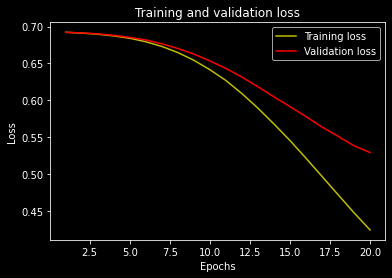

In [0]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

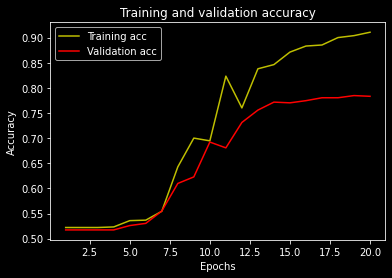

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
test_loss, test_acc = model.evaluate(test_padded, y_test)
print(test_acc)

25000/25000 [==============================] - 1s 35us/step
0.8842800259590149


### Internal Embedding + Average (KERAS Multiclass)
https://towardsdatascience.com/machine-learning-sentiment-analysis-and-word-embeddings-python-keras-example-4dfb93c5a6cf

In [0]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, Dense
from keras.preprocessing.text import Tokenizer

Tokenizer and padding

In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
from keras.preprocessing.text import Tokenizer

# Init all Hyperparameters
OUTPUT_DIM = len(y_train_hotvec[0])
MAX_NUM_WORDS = 5000
MAX_LEN = 128
oov_token = '<UNK>' # Required only if test is not given 
pad_type = 'post'
trunc_type = 'post'

# Avoid UNK words 
X = np.concatenate((X_train, X_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = min(MAX_LEN, max([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)


In [0]:
num_words

5000

In [138]:
maxlen

63

DL Arch

In [139]:
# KERAS Architecture 
# Nice refrence to use embedding vectors in KERAS https://realpython.com/python-keras-text-classification/
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=16, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(OUTPUT_DIM, activation='sigmoid'))
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 63, 16)            80000     
_________________________________________________________________
global_average_pooling1d_14  (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 102       
Total params: 80,374
Trainable params: 80,374
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    train_padded,
    y_train_hotvec,
    epochs=50,
    batch_size=512,
    validation_split=0.1,
    shuffle=True
)

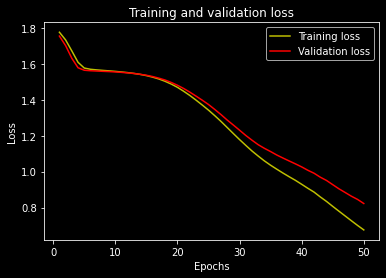

In [142]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

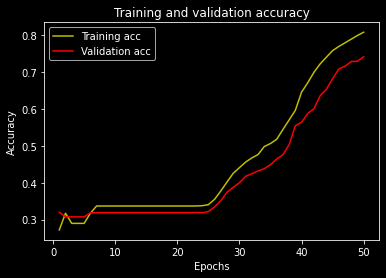

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [144]:
test_loss, test_acc = model.evaluate(test_padded, y_test_hotvec)
print(test_acc)

ValueError: ignored

In [145]:
y_pred = model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))


2000/2000 [==============================] - 0s 20us/step
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       581
           1       0.72      0.90      0.80       695
           2       0.64      0.06      0.10       159
           3       0.77      0.78      0.78       275
           4       0.49      0.74      0.59       224
           5       0.00      0.00      0.00        66

    accuracy                           0.74      2000
   macro avg       0.59      0.55      0.52      2000
weighted avg       0.73      0.74      0.71      2000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
y_pred_bool = np.argmax(y_pred, axis=1)

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 3, 2, 0, 0, 1, 2, 0, 1, 0, 3, 1, 0, 1,
       1, 0, 0, 4, 3, 0, 4, 0, 4, 3, 0, 3, 0, 1, 5, 0, 1, 1, 0, 0, 1, 0,
       1, 3, 1, 1, 4, 4, 0, 4, 1, 1, 1, 0, 0, 1, 0, 3, 0, 0, 2, 1, 3, 2,
       0, 0, 4, 5, 1, 2, 3, 1, 2, 3, 1, 0, 1, 2, 1, 3, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 4, 3, 4, 2, 3, 2, 0, 4, 0])

### Tokenizers . (Can replace the KERAS tokenizer but missing vocab sise limitation)


1. Uni-Gram Tokenizations 

In [0]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            #self.vocab.update(generate_bigrams(s.split(' ')))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word 

In [0]:
X = np.concatenate((X_train, X_test), axis=0)

In [0]:
# construct vocab and indexing
inputs = ConstructVocab(X)


num_words = len(inputs.vocab)

In [0]:
# vectorize to tensor
train_sequences = [[inputs.word2idx[s] for s in es.split(' ')]  for es in X_train]

In [0]:
maxlen = max([len(x) for x in train_sequences])

In [0]:
# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)

In [0]:
# vectorize to tensor
test_sequences = [[inputs.word2idx[s] for s in es.split(' ')]  for es in X_test]
# Pad the training sequences
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)

1.1 KERAS Tokenization

In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'


# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen = 256

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Output the results of our work
#print("Word index:\n", word_index)
#print("\nTraining sequences:\n", train_sequences)
#print("\nPadded training sequences:\n", train_padded)
#print("\nPadded training shape:", train_padded.shape)
#print("Training sequences data type:", type(train_sequences))
#print("Padded Training sequences data type:", type(train_padded))

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

#print("Testing sequences:\n", test_sequences)
#print("\nPadded testing sequences:\n", test_padded)
#print("\nPadded testing shape:",test_padded.shape)

#for x, y in zip(test_data, test_padded):
#  print('{} -> {}'.format(x, y))

#print("\nWord index (for reference):", word_index)


2. Bigram tokenization

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
    def generate_bigrams(x):
      n_grams = set(zip(*[x[i:] for i in range(2)]))
      for n_gram in n_grams:
          x.append(' '.join(n_gram))
      return x

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(generate_bigrams(s.split(' ')))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word 

In [0]:
X = np.concatenate((X_train, X_test), axis=0)

In [0]:
# construct vocab and indexing
inputs = ConstructVocab(X)
num_words = len(inputs.vocab)

In [0]:
# vectorize to tensor
train_sequences = [[inputs.word2idx[s] for s in generate_bigrams(es.split(' '))]  for es in X_train]

In [0]:
maxlen = max([len(x) for x in train_sequences])

In [0]:
# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)

In [0]:
# vectorize to tensor
test_sequences = [[inputs.word2idx[s] for s in generate_bigrams(es.split(' '))]  for es in X_test]
# Pad the training sequences
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)

### GRU + GLOVE


1. Uni-Gram Tokenizations & Padding

In [0]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            #self.vocab.update(generate_bigrams(s.split(' ')))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word 

In [0]:
X = np.concatenate((X_train, X_test), axis=0)

# construct vocab and indexing
inputs = ConstructVocab(X)
num_words = len(inputs.vocab)

# vectorize to tensor
train_sequences = [[inputs.word2idx[s] for s in es.split(' ')]  for es in X_train]

maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
#train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)
train_padded = [pad_sequences(x, maxlen) for x in train_sequences]

In [0]:

# vectorize to tensor
test_sequences = [[inputs.word2idx[s] for s in es.split(' ')]  for es in X_test]
# Pad the training sequences
test_padded = [pad_sequences(x, maxlen) for x in test_sequences]

3. Data Loader

In [0]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = MyData(train_padded, y_train_hotvec)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


14,400 training samples
1,600 validation samples


In [0]:
train_dataset[0]

(array([13185,  7367,  9426,   542,  7379,  4801,  3414,    23,   669,
        15447,    13,  6329,   184,   172,  8743,    23,  5509, 12999,
         8976,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), array([0, 1]), 19)

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
TRAIN_N_BATCH = train_size // batch_size
VAL_N_BATCH = val_size // batch_size

In [0]:
train_size

6228

In [0]:
# define dict to hold a word and its vector
glove = {}
# read the word embeddings file ~820MB
f = open('/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
# check the length
len(glove) # 400000

# Build pre-trained embeddings 
emb_dim = 100
matrix_len = len(inputs.vocab)+1
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found = 0
s=[]

weights_matrix[0] = np.zeros((emb_dim,))   # <pad> 
for i, word in enumerate(inputs.vocab):
    try: 
        weights_matrix[i+1] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i+1] = np.zeros((emb_dim,))

pretrained_embeddings = weights_matrix


4. Model

After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/gru-model.png?raw=true)

In [0]:
import torch.nn as nn
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        #self.embeddings = nn.Embedding.from_pretrained(glove_vectors, freeze=True).
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

5. Pretesting model

In [0]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_size=len(inputs.word2idx), embedding_dim=100, hidden_units=1024, batch_sz=batch_size, output_size=6)
# Load Glove parameters 
model.embedding.weight.data.copy_(torch.tensor(pretrained_embeddings))

# obtain one sample from the data iterator
it = iter(train_dataloader)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

In [0]:
type(xs)

torch.Tensor

In [0]:
type(lens)

torch.Tensor

In [0]:
num_words

16184

In [0]:
type(xs)

torch.Tensor

In [0]:
lens

tensor([42, 40, 35, 34, 29, 28, 27, 24, 21, 20, 20, 19, 18, 17, 17, 16, 15, 15,
        14, 14, 14, 14, 14, 12, 12, 11,  8,  8,  7,  7,  6,  5])

In [0]:
lens

tensor([34, 29, 28, 26, 25, 25, 23, 23, 22, 20, 17, 17, 14, 13, 12, 11, 11,  9,
         9,  8,  8,  8,  8,  7,  7,  7,  6,  6,  6,  6,  4,  4])

device(type='cuda', index=0)

5. Training the model

5.1 Model

In [0]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_size=len(inputs.word2idx), embedding_dim=100, hidden_units=1024, batch_sz=batch_size, output_size=6)
# Load Glove parameters 
model.embedding.weight.data.copy_(torch.tensor(pretrained_embeddings))
#model.embedding.weight.requires_grad = False
model.to(device)

EmoGRU(
  (embedding): Embedding(16185, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(100, 1024)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)

5.2 Optimizer

In [0]:
### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(param for param in model.parameters() if param.requires_grad == True)

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy


# Here is code for freezing the embedding layer weights
# 1.model.embeddings.weight.requires_grad = False
# 2. optimizer = torch.optim.Adam(param for param in model.parameters() if param.requires_grad == True)

5.3 Training loop

In [0]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataloader):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(validation_dataloader):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [0]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(16185, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(100, 1024)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)>

Evaluation

In [0]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to("cuda")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

### GRU + GLOVE Primary


Load Glove

In [27]:
# define dict to hold a word and its vector
glove = {}
# read the word embeddings file ~820MB
f = open('/gdrive/My Drive/DataSet/Glove/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
# check the length
len(glove) # 400000

400000

1. My Tokenization, padding and Glove

In [0]:
def my_pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            #self.vocab.update(generate_bigrams(s.split(' ')))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word 

In [0]:
X = np.concatenate((X_train, X_test), axis=0)

# construct vocab and indexing
inputs = ConstructVocab(X)
num_words = len(inputs.vocab)

# vectorize to tensor
train_sequences = [[inputs.word2idx[s] for s in es.split(' ')]  for es in X_train]

maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
#train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)
train_padded = [my_pad_sequences(x, maxlen) for x in train_sequences]

# vectorize to tensor
test_sequences = [[inputs.word2idx[s] for s in es.split(' ')]  for es in X_test]
# Pad the training sequences
test_padded = [my_pad_sequences(x, maxlen) for x in test_sequences]

num_words = len(inputs.word2idx)

In [0]:
# Build pre-trained embeddings from KERAS tokenization
emb_dim = 100
matrix_len = len(inputs.vocab)+1
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found = 0
s=[]

weights_matrix[0] = np.zeros((emb_dim,))   # <pad> 
for i, word in enumerate(inputs.vocab):
    try: 
        weights_matrix[i+1] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i+1] = np.zeros((emb_dim,))

pretrained_embeddings = weights_matrix

In [0]:
num_words

15502

1.1 KERAS Tokenization, padding and Glove

Elegant option: https://keras.io/examples/pretrained_word_embeddings/

In [0]:
def my_pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
len(y_test_hotvec[0])

2

In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
from keras.preprocessing.text import Tokenizer

# Init all Hyperparameters
OUTPUT_DIM = len(y_train_hotvec[0])
MAX_NUM_WORDS = 2000
EMBEDDING_DIM = 100 # Glove
MAX_LEN = 128 
HIDDEN_DIM = 1024
BATCH_SIZE = 32
oov_token = '<UNK>' # Required only if test is not given 

# Avoid UNK words 
X = np.concatenate((X_train, X_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = min(MAX_LEN, max([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = [my_pad_sequences(x, maxlen) for x in train_sequences]

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = [my_pad_sequences(x, maxlen) for x in test_sequences]


In [0]:
maxlen


64

In [0]:
# From KERAS documentation
# prepare embedding matrix
words_not_found = 0
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    try:     
      embedding_vector = glove[word]
    except KeyError:
        # words not found in embedding index will be all-zeros.
      words_not_found += 1


In [0]:
words_not_found

447

2. Data Loader

In [0]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = MyData(train_padded, y_train_hotvec)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Combine the test inputs into a TensorDataset.
test_dataset = MyData(test_padded, y_test_hotvec)
test_size=len(test_dataset)

TRAIN_N_BATCH = train_size // BATCH_SIZE
VAL_N_BATCH = val_size // BATCH_SIZE
TEST_N_BATCH = test_size // BATCH_SIZE

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

90,849 training samples
10,095 validation samples
40,378 test samples


In [0]:
test_dataset[0]

In [0]:
X_test[0]

'no movement , no yuks , not much of anything'

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )


3. Model

After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/gru-model.png?raw=true)

In [0]:
import torch.nn as nn
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        #self.embeddings = nn.Embedding.from_pretrained(glove_vectors, freeze=True).
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, batch_size, device):
        return torch.zeros((1, batch_size, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(len(lens),device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

4. Pretesting model

In [0]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [0]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")

model = EmoGRU(vocab_size=num_words, embedding_dim=EMBEDDING_DIM, hidden_units=HIDDEN_DIM, batch_sz=BATCH_SIZE, output_size=OUTPUT_DIM)
# Load Glove parameters 
model.embedding.weight.data.copy_(torch.tensor(embedding_matrix))

model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataloader)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([64, 32])
torch.Size([32, 2])


5. Training the model

5.1 Model

In [0]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")

model = EmoGRU(vocab_size=num_words, embedding_dim=EMBEDDING_DIM, hidden_units=HIDDEN_DIM, batch_sz=BATCH_SIZE, output_size=OUTPUT_DIM)
# Load Glove parameters 
model.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
#model.embedding.weight.requires_grad = False
model.to(device)

EmoGRU(
  (embedding): Embedding(2000, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(100, 1024)
  (fc): Linear(in_features=1024, out_features=19, bias=True)
)

5.2 Optimizer

In [0]:
### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())   #Default:  lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, Other options: lr = 2e-5
#optimizer = torch.optim.Adam(param for param in model.parameters() if param.requires_grad == True)

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy


# Here is code for freezing the embedding layer weights
# 1.model.embeddings.weight.requires_grad = False
# 2. optimizer = torch.optim.Adam(param for param in model.parameters() if param.requires_grad == True)

5.3 Training loop

In [0]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataloader):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(validation_dataloader):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.1547
Epoch 1 Batch 100 Val. Loss 0.1228
Epoch 1 Batch 200 Val. Loss 0.1268
Epoch 1 Batch 300 Val. Loss 0.1005
Epoch 1 Batch 400 Val. Loss 0.1059
Epoch 1 Batch 500 Val. Loss 0.0877
Epoch 1 Batch 600 Val. Loss 0.0946
Epoch 1 Batch 700 Val. Loss 0.0840
Epoch 1 Batch 800 Val. Loss 0.0784
Epoch 1 Batch 900 Val. Loss 0.0820
Epoch 1 Batch 1000 Val. Loss 0.0917
Epoch 1 Batch 1100 Val. Loss 0.0917
Epoch 1 Batch 1200 Val. Loss 0.0798
Epoch 1 Batch 1300 Val. Loss 0.0962
Epoch 1 Batch 1400 Val. Loss 0.0652
Epoch 1 Batch 1500 Val. Loss 0.0892
Epoch 1 Batch 1600 Val. Loss 0.0821
Epoch 1 Batch 1700 Val. Loss 0.0986
Epoch 1 Batch 1800 Val. Loss 0.1053
Epoch 1 Batch 1900 Val. Loss 0.0900
Epoch 1 Batch 2000 Val. Loss 0.0790
Epoch 1 Batch 2100 Val. Loss 0.0647
Epoch 1 Batch 2200 Val. Loss 0.0774
Epoch 1 Batch 2300 Val. Loss 0.0733
Epoch 1 Batch 2400 Val. Loss 0.0738
Epoch 1 Batch 2500 Val. Loss 0.0902
Epoch 1 Batch 2600 Val. Loss 0.0706
Epoch 1 Batch 2700 Val. Loss 0.0996
Epoc

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
device

device(type='cpu')

In [0]:
time.time()

In [0]:
len(lens)

NameError: ignored

In [0]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(10001, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(100, 1024)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)>

Evaluation

In [0]:
len(test_dataloader)

63

In [0]:
test_accuracy = 0
all_predictions = []


device = "cuda" # we don't need GPU to do testing
model.to("cuda")

for (batch, (inp, targ, lens)) in enumerate(test_dataloader):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  73.0680411202567


In [0]:
len(test_dataloader)

782

# Distill

# Define functions

In [44]:
 #We'll use Average Glove here 
from nltk import word_tokenize
import nltk
nltk.download('punkt')

# define dict to hold a word and its vector
glove = {}
# read the word embeddings file ~820MB
f = open('/gdrive/My Drive/DataSet/Glove/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
# check the length
len(glove) # 400000

def MeanSentenceGlove(texts):
# create vector for each sentences
# list to hold vector 
  sentence_vectors = []
# create vector for each clean normalized sentence
  for i in texts:
      if len(i) != 0:
          v = sum([glove.get(w, np.zeros((100,))) for w in i.split(' ')])/(len(i.split(' '))+0.001)
          #print(len(i))
      else:
          v = np.zeros((100,))
      sentence_vectors.append(v)
  #print('Total vectors created:',len(sentence_vectors))
  return(sentence_vectors)

def AvgGlove(texts):
# create vector for each sentences
# list to hold vector 
  vectors = []
# create vector for each clean normalized sentence
  for i in texts:
      #vectors.append(np.average(glove.get(word_tokenize(i)), axis =0))
      vectors.append(np.average([glove.get(w, np.zeros((100,))) for w in word_tokenize(i)], axis = 0))
  return np.array(vectors)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0
import pandas as pd
import re
from os import system, listdir
from os.path import isfile, join
from random import shuffle

system('wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"')
system('tar -xzf "aclImdb_v1.tar.gz"')

def create_data_frame(folder: str) -> pd.DataFrame:
    '''
    folder - the root folder of train or test dataset
    Returns: a DataFrame with the combined data from the input folder
    '''
    pos_folder = f'{folder}/pos' # positive reviews
    neg_folder = f'{folder}/neg' # negative reviews
    
    def get_files(fld: str) -> list:
        '''
        fld - positive or negative reviews folder
        Returns: a list with all files in input folder
        '''
        return [join(fld, f) for f in listdir(fld) if isfile(join(fld, f))]
    
    def append_files_data(data_list: list, files: list, label: int) -> None:
        '''
        Appends to 'data_list' tuples of form (file content, label)
        for each file in 'files' input list
        '''
        for file_path in files:
            with open(file_path, 'r') as f:
                text = f.read()
                data_list.append((text, label))
    
    pos_files = get_files(pos_folder)
    neg_files = get_files(neg_folder)
    
    data_list = []
    append_files_data(data_list, pos_files, 1)
    append_files_data(data_list, neg_files, 0)
    shuffle(data_list)
    
    text, label = tuple(zip(*data_list))
    # replacing line breaks with spaces
    text = list(map(lambda txt: re.sub('(<br\s*/?>)+', ' ', txt), text))
    
    return pd.DataFrame({'text': text, 'label': label})

imdb_train = create_data_frame('aclImdb/train')
imdb_test = create_data_frame('aclImdb/test')

system("mkdir 'csv'")
imdb_train.to_csv('csv/imdb_train.csv', index=False)
imdb_test.to_csv('csv/imdb_test.csv', index=False)

Load ED6 dataset for data augmentation 

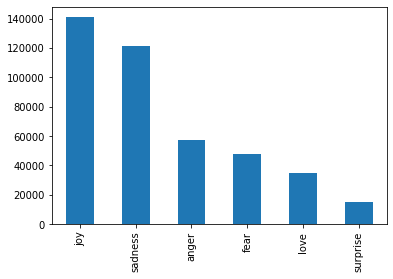

In [100]:
import pickle

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

# load data
data = load_from_pickle("/gdrive/My Drive/DataSet/ED6/merged_training.pkl")
data.emotions.value_counts().plot.bar()

In [101]:
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


In [0]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

In [0]:
# sampling
data_aug_6ed = data.sample(n=50000);

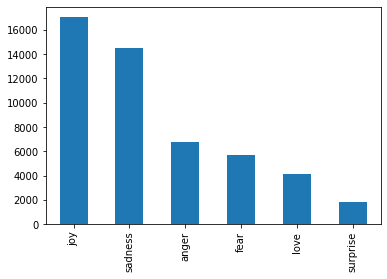

In [104]:
data_aug_6ed.emotions.value_counts().plot.bar()

In [0]:
# Save csv file 
data_aug_6ed.to_csv(r'/gdrive/My Drive/DataSet/ED6/data_augmentation_ED6.csv')

In [0]:
df = pd.read_csv('/gdrive/My Drive/DataSet/ED6/data_augmentation_ED6.csv')

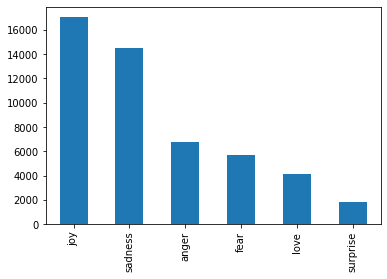

In [107]:
df.emotions.value_counts().plot.bar()

# Distill Methods

BOW

In [124]:
# Run regression with MSE(Logit)
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.metrics import matthews_corrcoef

model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LinearRegression()).fit(X_train, logits_train)
predicted = model.predict(X_test)
flat_predicted=torch.max(torch.tensor(predicted),1)[1]
print(classification_report(y_test, flat_predicted))
print(matthews_corrcoef(y_test, flat_predicted))


              precision    recall  f1-score   support

           0       0.90      0.90      0.90       581
           1       0.88      0.93      0.90       695
           2       0.80      0.72      0.76       159
           3       0.89      0.83      0.86       275
           4       0.80      0.82      0.81       224
           5       0.75      0.62      0.68        66

    accuracy                           0.87      2000
   macro avg       0.84      0.80      0.82      2000
weighted avg       0.87      0.87      0.87      2000

0.8238767404734336


### FT-MSE(logit)
Distill: Internal Embedding + Average (KERAS Multiclass)
https://towardsdatascience.com/machine-learning-sentiment-analysis-and-word-embeddings-python-keras-example-4dfb93c5a6cf

In [0]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, Dense
from keras.preprocessing.text import Tokenizer

Tokenizer and padding

In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
from keras.preprocessing.text import Tokenizer

# Init all Hyperparameters
OUTPUT_DIM = len(y_train_hotvec[0])
MAX_NUM_WORDS = 15000
MAX_LEN = 128
oov_token = '<UNK>' # Required only if test is not given 
pad_type = 'post'
trunc_type = 'post'

# Avoid UNK words 
X = np.concatenate((X_train, X_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = min(MAX_LEN, max([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)


DL Arch

In [297]:
# KERAS Architecture 
# Nice refrence to use embedding vectors in KERAS https://realpython.com/python-keras-text-classification/
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=16, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(OUTPUT_DIM))
model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 68, 16)            240000    
_________________________________________________________________
global_average_pooling1d_26  (None, 16)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_52 (Dense)             (None, 6)                 102       
Total params: 240,374
Trainable params: 240,374
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy']
)

In [299]:
history = model.fit(
    train_padded,
    logits_train,
    epochs=50,
    batch_size=512,
    validation_split=0.1,
    shuffle=True
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 0s 8us/step - loss: 6.9371 - accuracy: 0.3334 - val_loss: 6.8249 - val_accuracy: 0.3240
Epoch 2/50
45000/45000 [==============================] - 0s 6us/step - loss: 6.7866 - accuracy: 0.3364 - val_loss: 6.7854 - val_accuracy: 0.3240
Epoch 3/50
45000/45000 [==============================] - 0s 6us/step - loss: 6.7374 - accuracy: 0.3364 - val_loss: 6.7317 - val_accuracy: 0.3240
Epoch 4/50
45000/45000 [==============================] - 0s 6us/step - loss: 6.6682 - accuracy: 0.3366 - val_loss: 6.6564 - val_accuracy: 0.3244
Epoch 5/50
45000/45000 [==============================] - 0s 6us/step - loss: 6.5751 - accuracy: 0.3502 - val_loss: 6.5590 - val_accuracy: 0.3674
Epoch 6/50
45000/45000 [==============================] - 0s 6us/step - loss: 6.4588 - accuracy: 0.3978 - val_loss: 6.4432 - val_accuracy: 0.3976
Epoch 7/50
45000/45000 [==============================] - 0s 6us/step - los

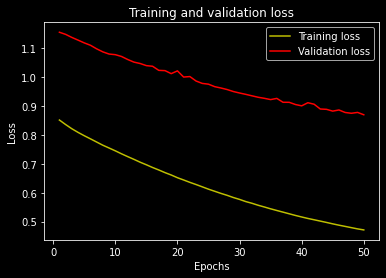

In [294]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

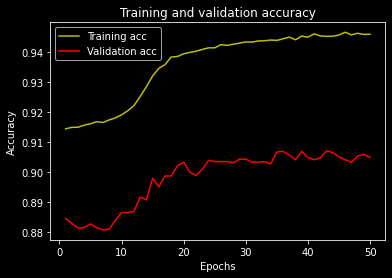

In [295]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [300]:
logits_pred = model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(logits_pred, axis=1)
print(classification_report(y_test, y_pred_bool))


2000/2000 [==============================] - 0s 15us/step
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       581
           1       0.78      0.98      0.87       695
           2       0.00      0.00      0.00       159
           3       0.47      0.67      0.56       275
           4       0.53      0.12      0.20       224
           5       0.00      0.00      0.00        66

    accuracy                           0.73      2000
   macro avg       0.44      0.46      0.42      2000
weighted avg       0.64      0.73      0.66      2000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
y_pred_bool[0:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

### FT-Psedu CE
Distill: Internal Embedding + Average (KERAS Multiclass)
https://towardsdatascience.com/machine-learning-sentiment-analysis-and-word-embeddings-python-keras-example-4dfb93c5a6cf

In [0]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, Dense
from keras.preprocessing.text import Tokenizer

Tokenizer and padding

In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
from keras.preprocessing.text import Tokenizer

# Init all Hyperparameters
OUTPUT_DIM = len(y_train_hotvec[0])
MAX_NUM_WORDS = 10000
MAX_LEN = 128
oov_token = '<UNK>' # Required only if test is not given 
pad_type = 'post'
trunc_type = 'post'

# Avoid UNK words 
X = np.concatenate((X_train, X_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = min(MAX_LEN, max([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)


DL Arch

In [236]:
# KERAS Architecture 
# Nice refrence to use embedding vectors in KERAS https://realpython.com/python-keras-text-classification/
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=16, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(OUTPUT_DIM, activation='sigmoid'))
model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 68, 16)            320000    
_________________________________________________________________
global_average_pooling1d_17  (None, 16)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 102       
Total params: 320,374
Trainable params: 320,374
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [238]:
history = model.fit(
    train_padded,
    y_train_psedu,
    epochs=50,
    batch_size=512,
    validation_split=0.1,
    shuffle=True
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 0s 10us/step - loss: 1.7290 - accuracy: 0.3365 - val_loss: 1.6521 - val_accuracy: 0.3240
Epoch 2/50
45000/45000 [==============================] - 0s 7us/step - loss: 1.5868 - accuracy: 0.3364 - val_loss: 1.5854 - val_accuracy: 0.3240
Epoch 3/50
45000/45000 [==============================] - 0s 7us/step - loss: 1.5607 - accuracy: 0.3364 - val_loss: 1.5787 - val_accuracy: 0.3240
Epoch 4/50
45000/45000 [==============================] - 0s 7us/step - loss: 1.5531 - accuracy: 0.3364 - val_loss: 1.5713 - val_accuracy: 0.3240
Epoch 5/50
45000/45000 [==============================] - 0s 7us/step - loss: 1.5412 - accuracy: 0.3364 - val_loss: 1.5558 - val_accuracy: 0.3242
Epoch 6/50
45000/45000 [==============================] - 0s 7us/step - loss: 1.5188 - accuracy: 0.3551 - val_loss: 1.5251 - val_accuracy: 0.4034
Epoch 7/50
45000/45000 [==============================] - 0s 7us/step - lo

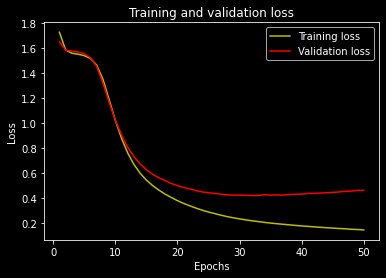

In [239]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

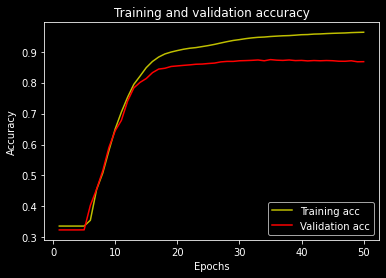

In [240]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [241]:
y_pred = model.predict(test_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))

2000/2000 [==============================] - 0s 16us/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       581
           1       0.92      0.91      0.91       695
           2       0.71      0.82      0.76       159
           3       0.82      0.89      0.85       275
           4       0.86      0.79      0.83       224
           5       0.56      0.52      0.54        66

    accuracy                           0.88      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.88      0.88      0.88      2000



### Loss=MSE(logit)+CE . (not completed)


In [0]:
from sklearn.metrics import accuracy_score

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')

from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, Dense
from keras.preprocessing.text import Tokenizer


from keras.models import * 
from keras.layers import *

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from torch.utils.data import DataLoader, SequentialSampler

Tokenizer and padding

In [0]:
# KERAS Tokenization
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
#https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
from keras.preprocessing.text import Tokenizer

# Init all Hyperparameters
OUTPUT_DIM = len(y_train_hotvec[0])
MAX_NUM_WORDS = 15000
MAX_LEN = 128
oov_token = '<UNK>' # Required only if test is not given 
pad_type = 'post'
trunc_type = 'post'

# Avoid UNK words 
X = np.concatenate((X_train, X_test), axis=0)

# Tokenize our training data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = min(MAX_LEN, max([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)


In [0]:
train_padded = train_padded[0:6656]
y_train_hotvec = y_train_hotvec[0:6656]


batch_size = 128

logits_train_dataloader = DataLoader(
            logits_train,  # The training samples.
            sampler = SequentialSampler(logits_train), 
            batch_size = batch_size,
        )

itr=iter(logits_train_dataloader)

DL Arch

In [0]:
def compute_kld(p_logit, q_logit):
    p = tf.nn.softmax(p_logit)
    q = tf.nn.softmax(q_logit)
    return tf.reduce_sum(p*(tf.math.log(p + 1e-16) - tf.math.log(q + 1e-16)), axis=1)

In [185]:
# KERAS Architecture 
# Nice refrence to use embedding vectors in KERAS https://realpython.com/python-keras-text-classification/
network = Sequential()
network.add(Embedding(input_dim=num_words, output_dim=16, input_length=maxlen))
network.add(GlobalAveragePooling1D())
network.add(Dense(16, activation='relu'))
network.add(Dense(OUTPUT_DIM))
network.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 16)            240000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 240,306
Trainable params: 240,306
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_input = Input((maxlen,))
p_logit = network( model_input )
p = Activation('softmax')( p_logit )
logits_train_batch= next(itr)
vat_loss = tf.reduce_mean(compute_kld( logits_train_batch, p_logit ))
vat_loss = 0

In [0]:
model_vat = Model(model_input , p )
model_vat.add_loss( vat_loss   )

model_vat.compile( 'adam' ,  'categorical_crossentropy'  ,  metrics=['accuracy'])

model_vat.metrics_names.append('vat_loss')
model_vat.metrics.append( vat_loss )

In [188]:
history = model_vat.fit(
    train_padded,
    y_train_hotvec,
    epochs=10,
    batch_size=128,
    validation_split=0.0,
    shuffle=False
)

Epoch 1/10
6656/6656 [==============================] - 0s 44us/step - loss: 0.6914 - accuracy: 0.5224
Epoch 2/10
6656/6656 [==============================] - 0s 31us/step - loss: 0.6854 - accuracy: 0.5284
Epoch 3/10
6656/6656 [==============================] - 0s 30us/step - loss: 0.6612 - accuracy: 0.6459
Epoch 4/10
6656/6656 [==============================] - 0s 30us/step - loss: 0.6032 - accuracy: 0.7903
Epoch 5/10
6656/6656 [==============================] - 0s 30us/step - loss: 0.5159 - accuracy: 0.8451
Epoch 6/10
6656/6656 [==============================] - 0s 31us/step - loss: 0.4208 - accuracy: 0.8801
Epoch 7/10
6656/6656 [==============================] - 0s 30us/step - loss: 0.3380 - accuracy: 0.9111
Epoch 8/10
6656/6656 [==============================] - 0s 31us/step - loss: 0.2733 - accuracy: 0.9304
Epoch 9/10
6656/6656 [==============================] - 0s 31us/step - loss: 0.2239 - accuracy: 0.9453
Epoch 10/10
6656/6656 [==============================] - 0s 30us/step - l

In [189]:
y_pred  = model_vat.predict( test_padded ).argmax(-1)
print( "Test accruracy " , accuracy_score(y_test , y_pred  ))

Test accruracy  0.8138385502471169


In [218]:
model_vat.fit( np.concatenate([train_padded]*50) , np.concatenate([y_train_hotvec]*50))
y_pred  = model_vat.predict( test_padded ).argmax(-1)
print( "Test accruracy " , accuracy_score(y_test , y_pred  ))

Epoch 1/1
332800/332800 [==============================] - 69s 206us/step - loss: 2.7681 - accuracy: 0.8636
Test accruracy  0.7929708951125755
